AIN311 CLASS PROJECT

MELİKE NUR DULKADİR & SARE NAZ ERSOY

# Career Path Predictor

Importing necessary libraries

In [326]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import tree,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [328]:
df = pd.read_csv('https://raw.githubusercontent.com/sayalideo/Job-Role-Prediction-/master/Data/roo_data.csv')
df.head()

,Acedamic percentage in Operating Systems,percentage in Algorithms,Percentage in Programming Concepts,Percentage in Software Engineering,Percentage in Computer Networks,Percentage in Electronics Subjects,Percentage in Computer Architecture,Percentage in Mathematics,Percentage in Communication skills,Hours working per day,...,Interested Type of Books,Salary Range Expected,In a Realtionship?,Gentle or Tuff behaviour?,Management or Technical,Salary/work,hard/smart worker,worked in teams ever?,Introvert,Suggested Job Role
0,69,63,78,87,94,94,87,84,61,9,...,Prayer books,salary,no,stubborn,Management,salary,hard worker,yes,no,Database Administrator
1,78,62,73,60,71,70,73,84,91,12,...,Childrens,salary,yes,gentle,Technical,salary,hard worker,no,yes,Project Manager
2,71,86,91,87,61,81,72,72,94,11,...,Travel,Work,no,stubborn,Management,work,hard worker,no,yes,Project Manager
3,76,87,60,84,89,73,62,88,69,7,...,Romance,Work,yes,gentle,Management,work,smart worker,yes,yes,Security Administrator
4,92,62,90,67,71,89,73,71,73,4,...,Cookbooks,salary,no,stubborn,Management,work,hard worker,yes,yes,Business Intelligence Analyst


In [329]:
df.columns

Index(['Acedamic percentage in Operating Systems', 'percentage in Algorithms',
       'Percentage in Programming Concepts',
       'Percentage in Software Engineering', 'Percentage in Computer Networks',
       'Percentage in Electronics Subjects',
       'Percentage in Computer Architecture', 'Percentage in Mathematics',
       'Percentage in Communication skills', 'Hours working per day',
       'Logical quotient rating', 'hackathons', 'coding skills rating',
       'public speaking points', 'can work long time before system?',
       'self-learning capability?', 'Extra-courses did', 'certifications',
       'workshops', 'talenttests taken?', 'olympiads',
       'reading and writing skills', 'memory capability score',
       'Interested subjects', 'interested career area ', 'Job/Higher Studies?',
       'Type of company want to settle in?',
       'Taken inputs from seniors or elders', 'interested in games',
       'Interested Type of Books', 'Salary Range Expected',
       'In a Rea

Some utils functions for understand the data clearly

In [330]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

In [331]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
   # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [332]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [333]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [334]:
def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [335]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [336]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [337]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [338]:
def plot_importance(model, features, save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(features)])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

In [339]:
check_df(df)

##################### Shape #####################
(20000, 39)
##################### Types #####################
Acedamic percentage in Operating Systems     int64
percentage in Algorithms                     int64
Percentage in Programming Concepts           int64
Percentage in Software Engineering           int64
Percentage in Computer Networks              int64
Percentage in Electronics Subjects           int64
Percentage in Computer Architecture          int64
Percentage in Mathematics                    int64
Percentage in Communication skills           int64
Hours working per day                        int64
Logical quotient rating                      int64
hackathons                                   int64
coding skills rating                         int64
public speaking points                       int64
can work long time before system?           object
self-learning capability?                   object
Extra-courses did                           object
certifications       

In [340]:
df.columns = ['Academic_Percentage_In_Operating_Systems', 'Algorithms_Percentage',
              'Programming_Concepts_Percentage',
              'Software_Engineering_Percentage', 'Computer_Networks_Percentage',
              'Electronics_Subjects_Percentage',
              'Computer_Architecture_Percentage', 'Mathematics_Percentage',
              'Communication_Skills_Percentage', 'Hours_Working_Per_Day',
              'Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
              'Public_Speaking_Points', 'Can_Work_Long_Time_Before_System',
              'Self-Learning_Capability', 'Extra_Courses_Did', 'Certifications',
              'Workshops', 'Talent_Tests_Taken', 'Olympiads',
              'Reading_And_Writing_Skills', 'Memory_Capability_Score',
              'Interested_Subjects', 'Interested_Career_Area', 'Job/Higher_Studies',
              'Type_Of_Company_Want_To_Settle_In',
              'Taken_Inputs_From_Seniors_Or_Elders', 'Interested_In_Games',
              'Interested_Type_Of_Books', 'Salary_Range_Expected',
              'Being_In_A_Relationship', 'Gentle_Or_Tuff_Behaviour',
              'Management_Or_Technical', 'Salary/Work', 'Worker_Type',
              'Worked_In_Teams_Ever', 'Introvert', 'Suggested_Job_Role']

In [341]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 20000
Variables: 39
cat_cols: 24
num_cols: 14
cat_but_car: 1


In [342]:
num_cols

['Academic_Percentage_In_Operating_Systems',
 'Algorithms_Percentage',
 'Programming_Concepts_Percentage',
 'Software_Engineering_Percentage',
 'Computer_Networks_Percentage',
 'Electronics_Subjects_Percentage',
 'Computer_Architecture_Percentage',
 'Mathematics_Percentage',
 'Communication_Skills_Percentage',
 'Hours_Working_Per_Day',
 'Logical_Quotient_Rating',
 'Hackathons',
 'Coding_Skills_Rating',
 'Public_Speaking_Points']

In [343]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [344]:
scaler = StandardScaler()
cols_to_scale = num_cols

#create and fit scaler
scaler.fit(df[cols_to_scale])

#scale selected data
df[cols_to_scale] = scaler.transform(df[cols_to_scale])


<AxesSubplot:>

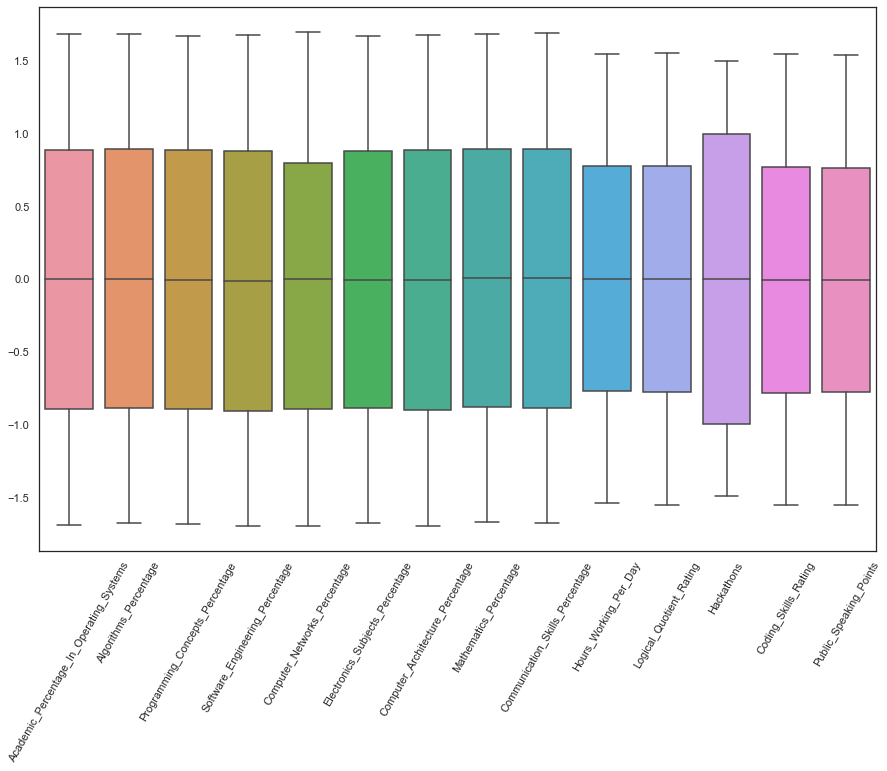

In [345]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
sns.boxplot(data=df[num_cols], ax=ax)

In [346]:
print("\n######## List of Categorical features ########\n")
for index,col in enumerate(cat_cols):
    print(index,col)


######## List of Categorical features ########

0 Can_Work_Long_Time_Before_System
1 Self-Learning_Capability
2 Extra_Courses_Did
3 Certifications
4 Workshops
5 Talent_Tests_Taken
6 Olympiads
7 Reading_And_Writing_Skills
8 Memory_Capability_Score
9 Interested_Subjects
10 Interested_Career_Area
11 Job/Higher_Studies
12 Type_Of_Company_Want_To_Settle_In
13 Taken_Inputs_From_Seniors_Or_Elders
14 Interested_In_Games
15 Salary_Range_Expected
16 Being_In_A_Relationship
17 Gentle_Or_Tuff_Behaviour
18 Management_Or_Technical
19 Salary/Work
20 Worker_Type
21 Worked_In_Teams_Ever
22 Introvert
23 Suggested_Job_Role


In [347]:
for i in cat_cols:
    print(df[i].value_counts(), end="\n\n")

yes    10020
no      9980
Name: Can_Work_Long_Time_Before_System, dtype: int64

yes    10102
no      9898
Name: Self-Learning_Capability, dtype: int64

no     10049
yes     9951
Name: Extra_Courses_Did, dtype: int64

r programming           2275
machine learning        2255
shell programming       2252
information security    2250
full stack              2239
hadoop                  2210
python                  2198
app development         2165
distro making           2156
Name: Certifications, dtype: int64

web technologies     2586
data science         2551
game development     2522
database security    2517
system designing     2516
hacking              2473
testing              2444
cloud computing      2391
Name: Workshops, dtype: int64

yes    10047
no      9953
Name: Talent_Tests_Taken, dtype: int64

yes    10079
no      9921
Name: Olympiads, dtype: int64

excellent    6696
poor         6683
medium       6621
Name: Reading_And_Writing_Skills, dtype: int64

poor         6677
exce

In [348]:
dummy_cols = ['Interested_Subjects',
              'Interested_Career_Area',
              'Type_Of_Company_Want_To_Settle_In',
              'Worker_Type','Certifications',
              'Workshops']
dummy_cols

['Interested_Subjects',
 'Interested_Career_Area',
 'Type_Of_Company_Want_To_Settle_In',
 'Worker_Type',
 'Certifications',
 'Workshops']

In [349]:
df.head()

,Academic_Percentage_In_Operating_Systems,Algorithms_Percentage,Programming_Concepts_Percentage,Software_Engineering_Percentage,Computer_Networks_Percentage,Electronics_Subjects_Percentage,Computer_Architecture_Percentage,Mathematics_Percentage,Communication_Skills_Percentage,Hours_Working_Per_Day,...,Interested_Type_Of_Books,Salary_Range_Expected,Being_In_A_Relationship,Gentle_Or_Tuff_Behaviour,Management_Or_Technical,Salary/Work,Worker_Type,Worked_In_Teams_Ever,Introvert,Suggested_Job_Role
0,-0.793450,-1.380807,0.096941,0.981950,1.700806,1.670279,0.986229,0.699022,-1.575875,0.390962,...,Prayer books,salary,no,stubborn,Management,salary,hard worker,yes,no,Database Administrator
1,0.098925,-1.479803,-0.396421,-1.694608,-0.594640,-0.689921,-0.404204,0.699022,1.393469,1.547595,...,Childrens,salary,yes,gentle,Technical,salary,hard worker,no,yes,Project Manager
2,-0.595145,0.896086,1.379680,0.981950,-1.592660,0.391837,-0.503520,-0.484608,1.690403,1.162051,...,Travel,Work,no,stubborn,Management,work,hard worker,no,yes,Project Manager
3,-0.099381,0.995082,-1.679160,0.684554,1.201796,-0.394896,-1.496687,1.093566,-0.784050,-0.380128,...,Romance,Work,yes,gentle,Management,work,smart worker,yes,yes,Security Administrator
4,1.487064,-1.479803,1.281008,-1.000686,-0.594640,1.178570,-0.404204,-0.583244,-0.388138,-1.536762,...,Cookbooks,salary,no,stubborn,Management,work,hard worker,yes,yes,Business Intelligence Analyst


In [350]:
cat_cols.remove("Suggested_Job_Role")
label_encoder = LabelEncoder()
for cat_col in cat_cols:
    if cat_col not in dummy_cols:
        df[cat_col]= label_encoder.fit_transform(df[cat_col])

In [351]:
df2 = df[dummy_cols]

In [352]:
df2 = pd.get_dummies(df2,prefix="dum",drop_first=True)

In [353]:
df = df.join(df2)

In [354]:
df.drop(columns=dummy_cols, inplace=True)

In [355]:
df.head()

,Academic_Percentage_In_Operating_Systems,Algorithms_Percentage,Programming_Concepts_Percentage,Software_Engineering_Percentage,Computer_Networks_Percentage,Electronics_Subjects_Percentage,Computer_Architecture_Percentage,Mathematics_Percentage,Communication_Skills_Percentage,Hours_Working_Per_Day,...,dum_python,dum_r programming,dum_shell programming,dum_data science,dum_database security,dum_game development,dum_hacking,dum_system designing,dum_testing,dum_web technologies
0,-0.793450,-1.380807,0.096941,0.981950,1.700806,1.670279,0.986229,0.699022,-1.575875,0.390962,...,0,0,1,0,0,0,0,0,0,0
1,0.098925,-1.479803,-0.396421,-1.694608,-0.594640,-0.689921,-0.404204,0.699022,1.393469,1.547595,...,0,0,0,0,1,0,0,0,0,0
2,-0.595145,0.896086,1.379680,0.981950,-1.592660,0.391837,-0.503520,-0.484608,1.690403,1.162051,...,0,0,0,0,0,0,0,0,0,1
3,-0.099381,0.995082,-1.679160,0.684554,1.201796,-0.394896,-1.496687,1.093566,-0.784050,-0.380128,...,1,0,0,1,0,0,0,0,0,0
4,1.487064,-1.479803,1.281008,-1.000686,-0.594640,1.178570,-0.404204,-0.583244,-0.388138,-1.536762,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

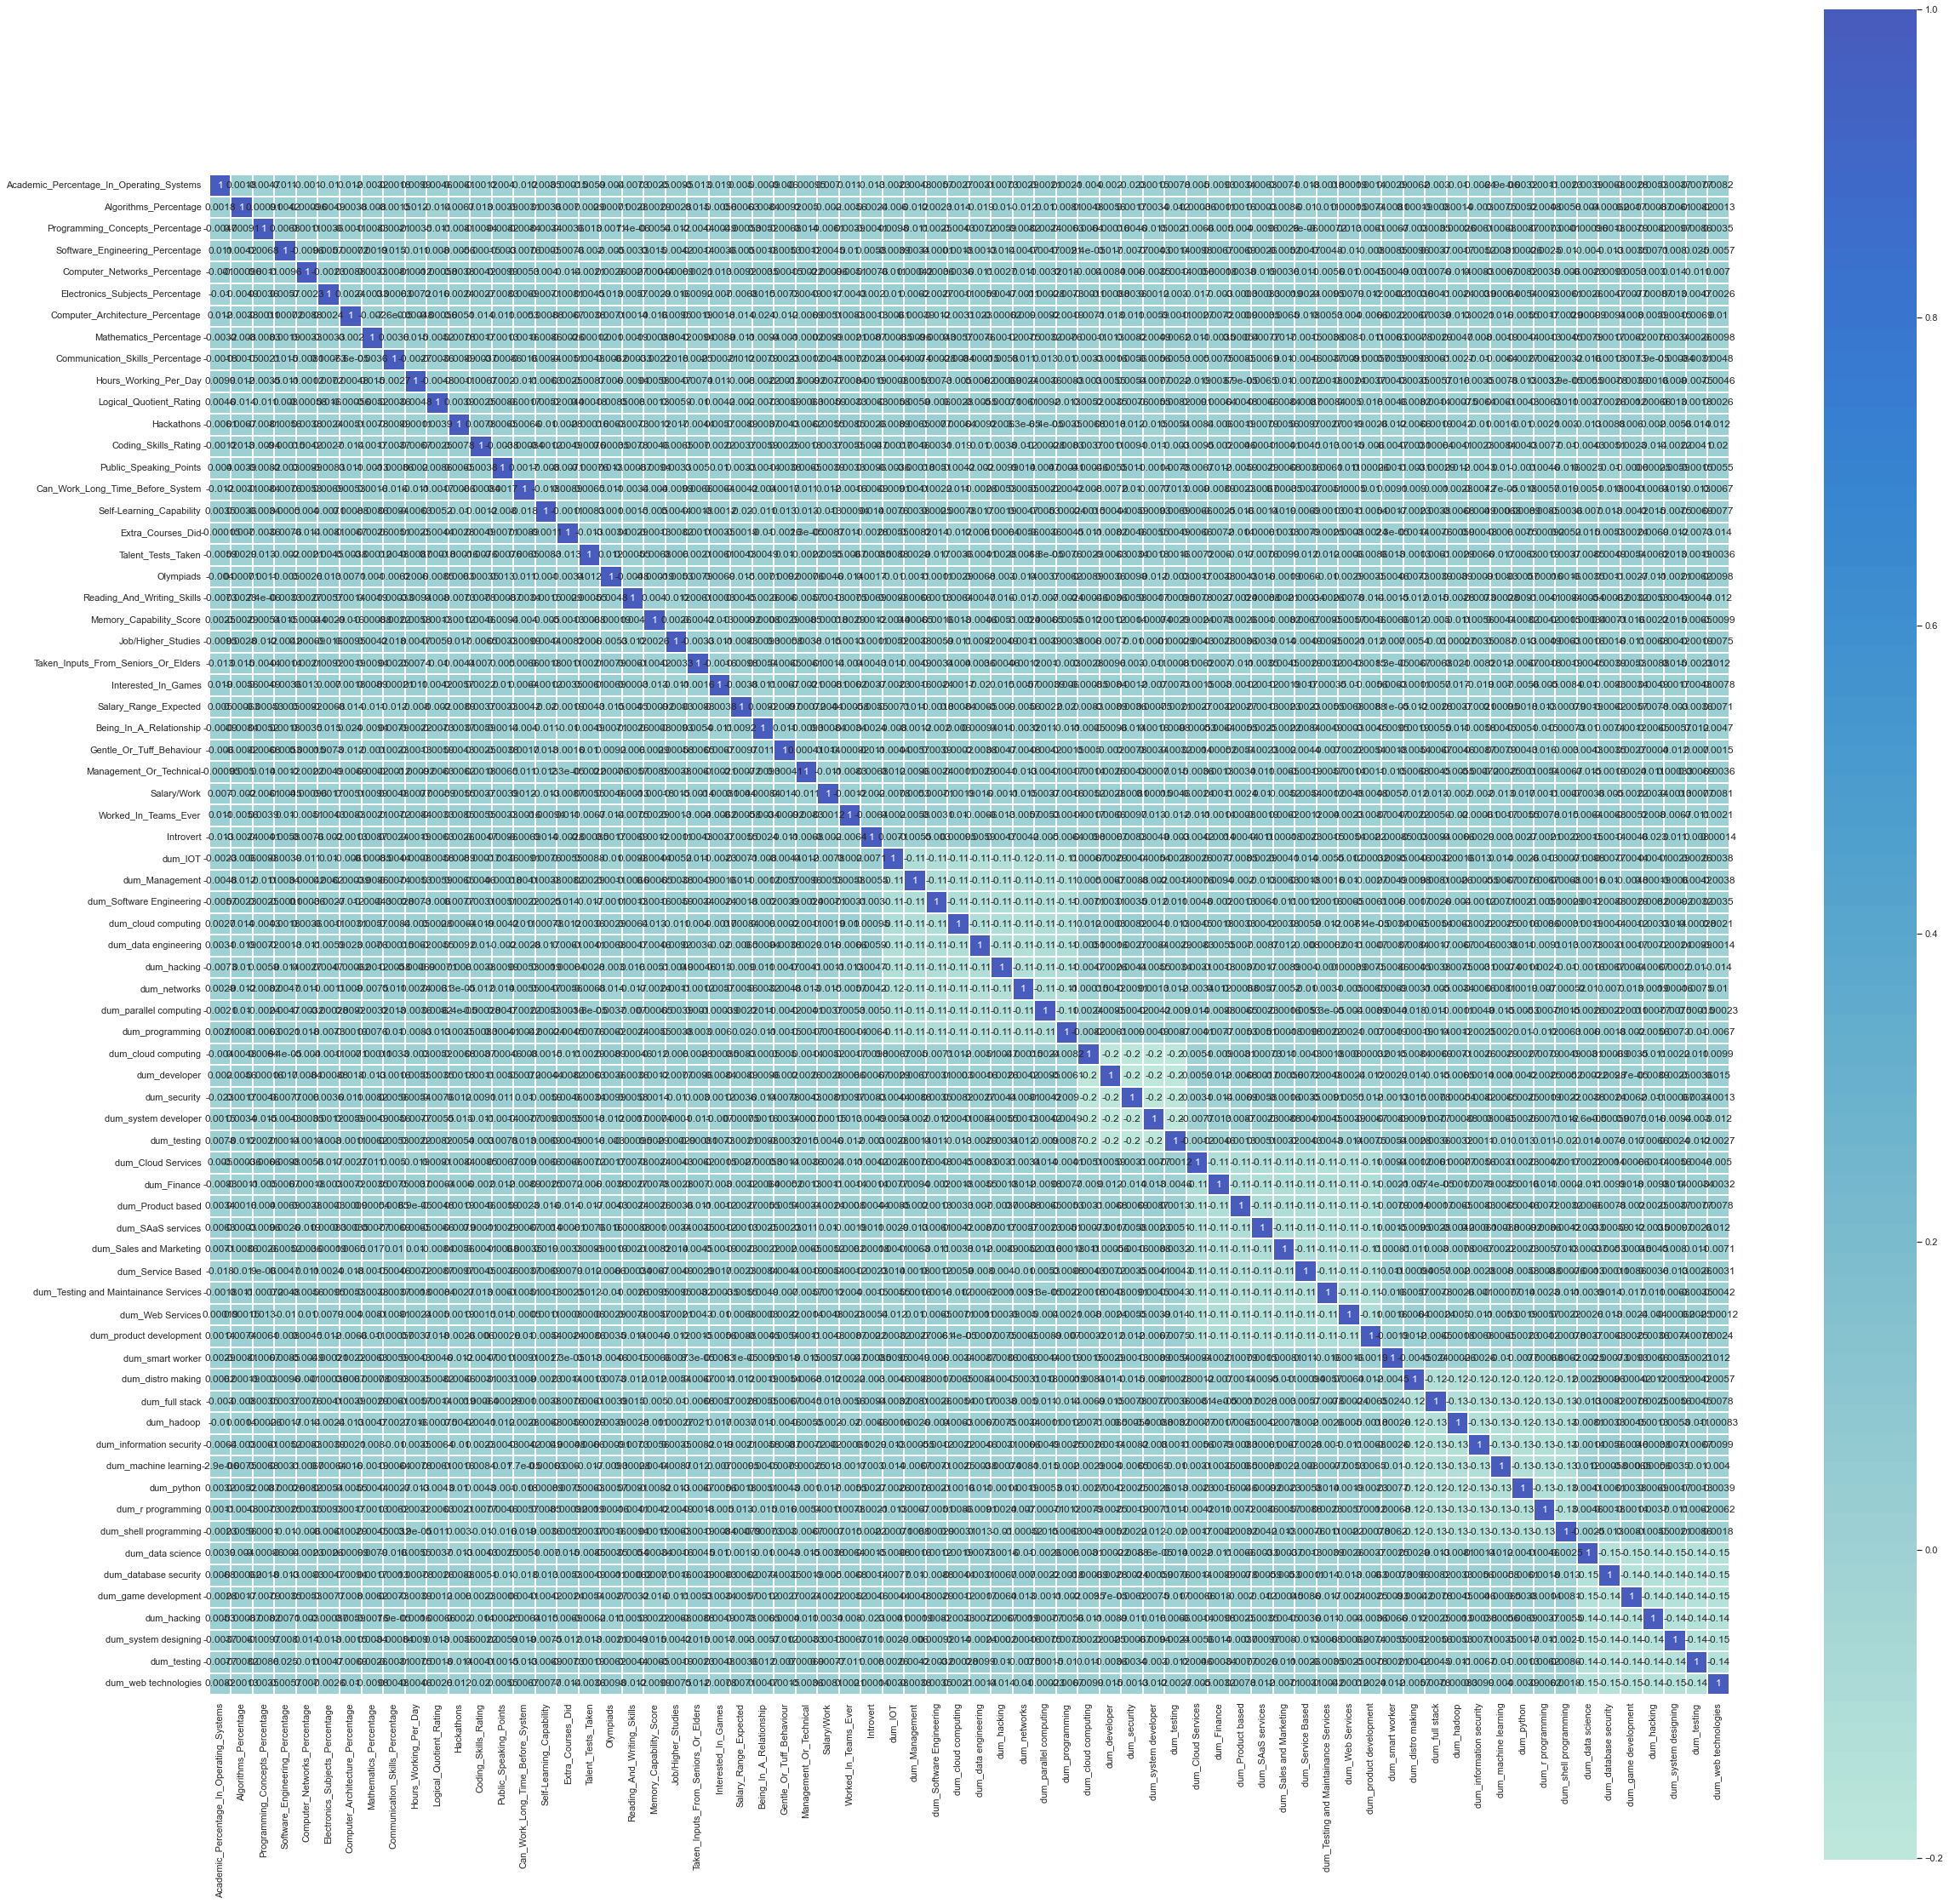

In [356]:
df3 = df.drop(columns = ["Suggested_Job_Role"])
df3 = df3.corr()
f,axes = plt.subplots(1,1,figsize = (40,40))
sns.heatmap(df3,square=True,annot = True,linewidth = .4,center = 2,ax = axes)

In [357]:
pca = PCA()
pca.fit(df3)
PC_components = np.arange(pca.n_components_) + 1

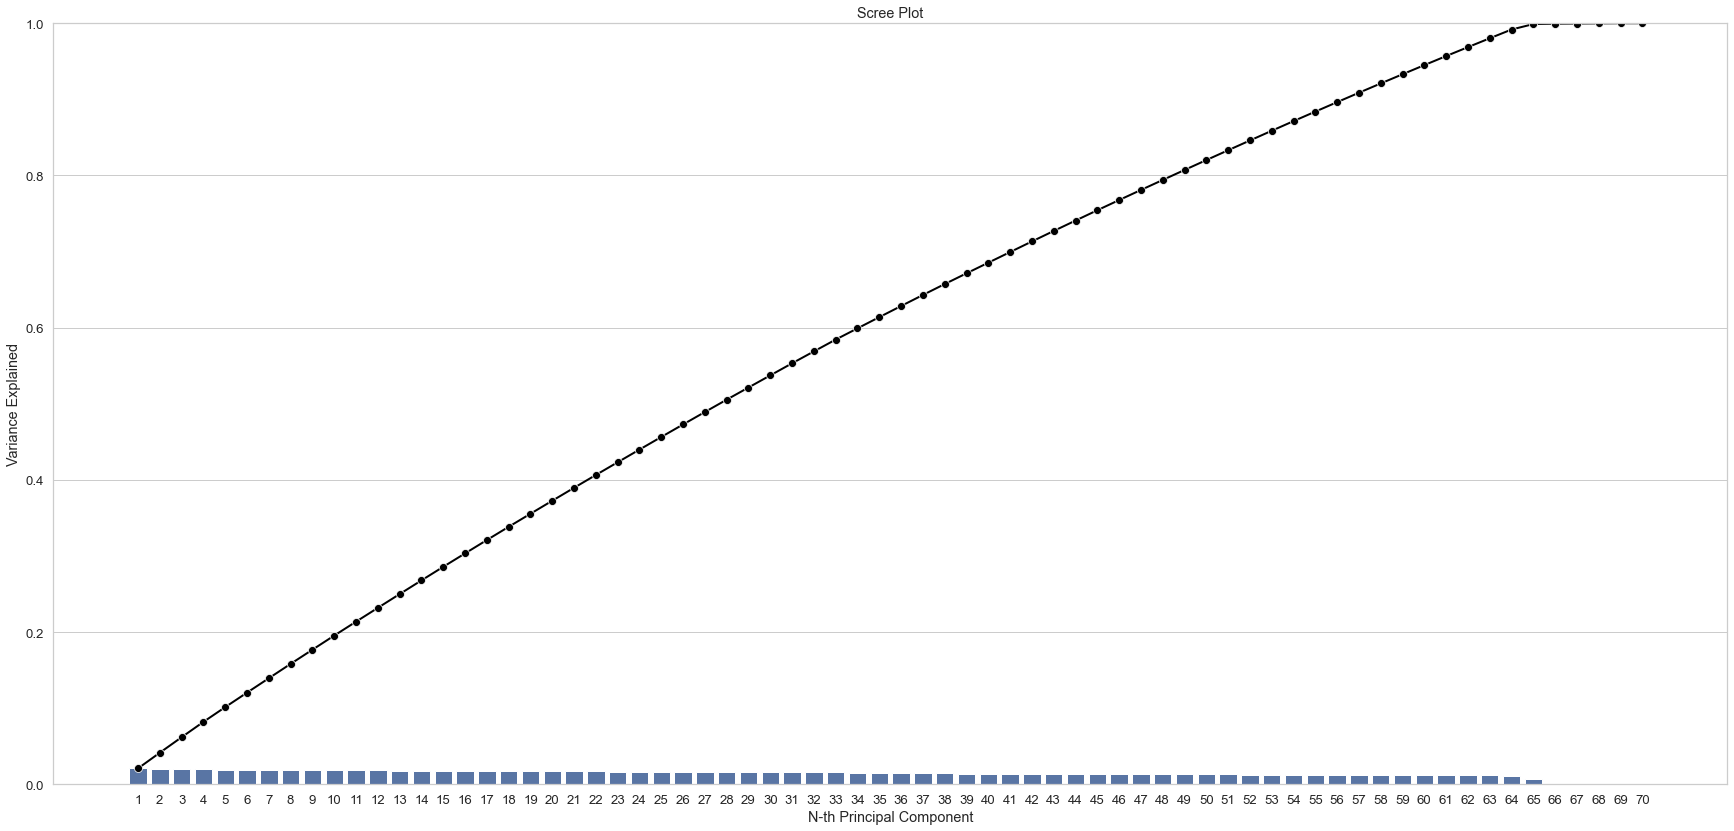

In [358]:
# Scree Plot
scree_plot = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(30, 14))
scree_plot = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
scree_plot = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()
#As you see after 18 feature relation, there is no change in data explainability.
#Which means we can use 18 feature to explain our data.

As you see, with specific 7 columns,we obtained nothing. So, we decided to find and drop them.

In [359]:
drop_list = high_correlated_cols(df)

In [360]:
drop_list

['dum_cloud computing',
 'dum_hacking',
 'dum_cloud computing',
 'dum_testing',
 'dum_hacking',
 'dum_testing']

In [361]:
df.drop(columns=drop_list, axis = 1, inplace=True)

We thought that the interested type of book is unnecessary and decided to drop that as well.

In [362]:
df.drop(columns=['Interested_Type_Of_Books'], axis=1,inplace=True)

In [363]:
df.corr()

,Academic_Percentage_In_Operating_Systems,Algorithms_Percentage,Programming_Concepts_Percentage,Software_Engineering_Percentage,Computer_Networks_Percentage,Electronics_Subjects_Percentage,Computer_Architecture_Percentage,Mathematics_Percentage,Communication_Skills_Percentage,Hours_Working_Per_Day,...,dum_information security,dum_machine learning,dum_python,dum_r programming,dum_shell programming,dum_data science,dum_database security,dum_game development,dum_system designing,dum_web technologies
Academic_Percentage_In_Operating_Systems,1.000000,0.001781,-0.004693,0.010691,-0.001003,-0.010402,0.011958,-0.003203,-0.001770,0.009925,...,-0.006420,-0.000003,0.003217,0.001074,-0.002261,0.003940,0.006849,-0.002835,-0.003674,0.008172
Algorithms_Percentage,0.001781,1.000000,0.000914,0.004178,-0.000961,-0.004914,-0.003793,-0.007968,-0.001485,0.011567,...,-0.002983,0.007509,0.005236,-0.004820,0.005553,0.003964,-0.000621,0.001724,-0.006055,-0.001255
Programming_Concepts_Percentage,-0.004693,0.000914,1.000000,0.006810,0.001120,0.003585,-0.001093,-0.008326,-0.002105,-0.003532,...,0.006082,0.006792,-0.008748,-0.007271,0.000101,-0.000958,0.001812,-0.007896,-0.009732,0.003464
Software_Engineering_Percentage,0.010691,0.004178,0.006810,1.000000,-0.009601,0.005680,0.000722,0.001932,0.015085,-0.011287,...,-0.005249,0.003070,-0.000265,-0.002466,-0.010080,-0.003953,-0.013119,-0.003544,0.007985,-0.005693
Computer_Networks_Percentage,-0.001003,-0.000961,0.001120,-0.009601,1.000000,-0.002255,0.008840,0.003276,-0.008065,-0.001204,...,0.008276,-0.006701,0.008151,0.003491,-0.005981,-0.002294,-0.009264,0.005298,0.013801,0.007036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dum_data science,0.003940,0.003964,-0.000958,-0.003953,-0.002294,0.002643,0.000995,0.007934,-0.015542,0.005481,...,-0.001417,0.012025,0.004143,0.004637,-0.002486,1.000000,-0.145079,-0.145243,-0.145046,-0.147345
dum_database security,0.006849,-0.000621,0.001812,-0.013119,-0.009264,-0.004657,-0.009384,0.001676,0.001324,0.000777,...,0.005647,0.000576,-0.006082,0.001753,-0.012597,-0.145079,1.000000,-0.144132,-0.143936,-0.146217
dum_game development,-0.002835,0.001724,-0.007896,-0.003544,0.005298,-0.007735,0.007971,0.006153,0.007336,-0.003866,...,-0.004636,-0.000646,0.003772,-0.001365,0.008111,-0.145243,-0.144132,1.000000,-0.144099,-0.146383
dum_system designing,-0.003674,-0.006055,-0.009732,0.007985,0.013801,0.013328,-0.001464,0.003400,-0.000841,0.008972,...,0.007134,0.003490,-0.001691,-0.010540,-0.002052,-0.145046,-0.143936,-0.144099,1.000000,-0.146184


<AxesSubplot:xlabel='Suggested_Job_Role', ylabel='count'>

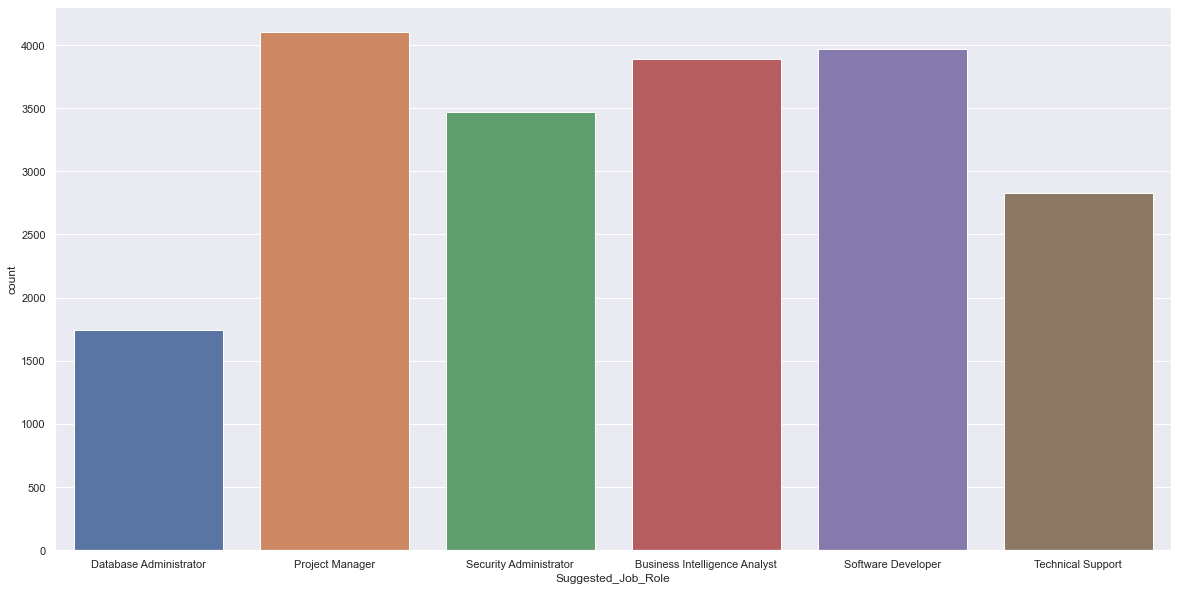

In [364]:
# Checking for data imbalanceness if any
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x = df["Suggested_Job_Role"])

Creating a decision tree model just for seeing the importance of features

In [365]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [41]:
clf = tree.DecisionTreeClassifier(random_state = 0)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[218  95 240 224 221 166]
 [100  46 105  98  93  86]
 [245 118 246 208 216 175]
 [206  86 210 178 202 172]
 [244 107 236 207 246 141]
 [169  70 172 159 171 124]]
  
accuracy= 17.633333333333333


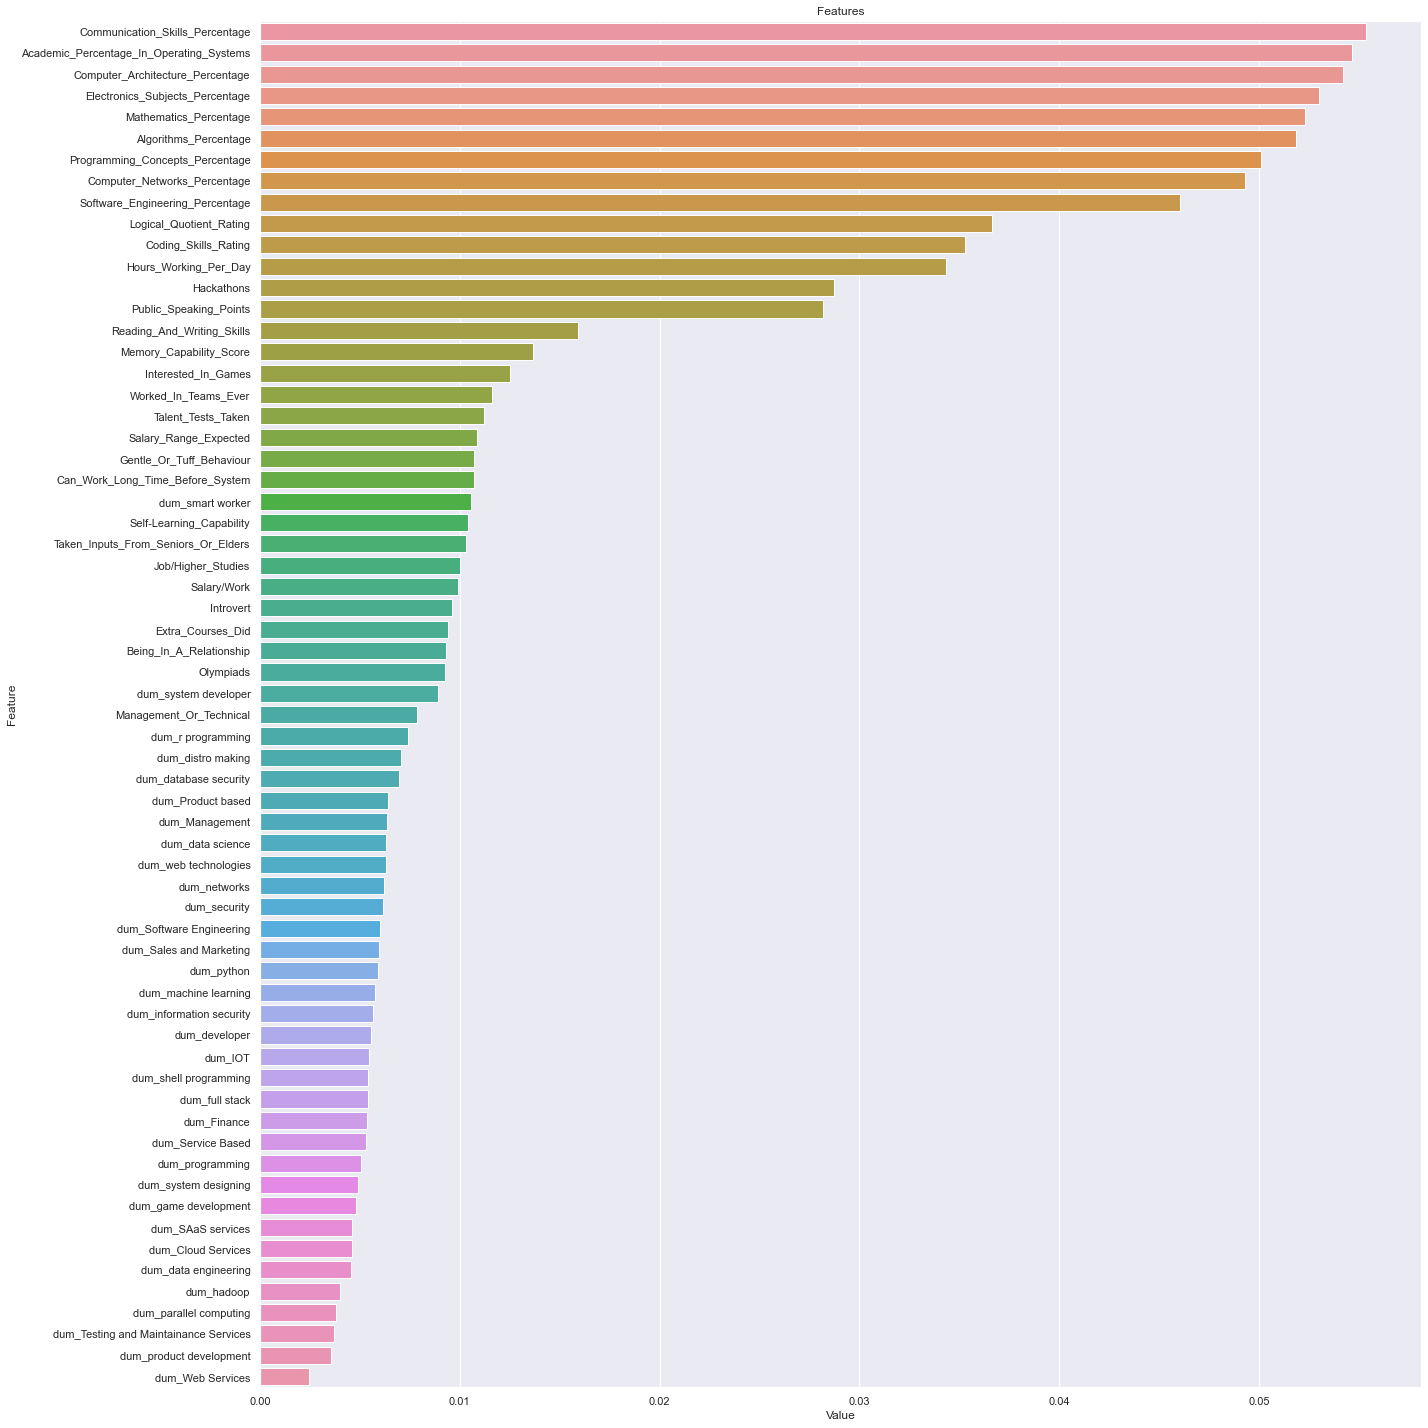

In [42]:
plot_importance(clf,X)

#### Feature Engineering

In [43]:
#Introvert no = 0
def categorise_confidence(row,col_avg):
    if row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 0:
        return 'self_confident'
    elif row['Public_Speaking_Points'] > col_avg and row['Introvert'] == 1:
        return 'only_introvert'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 0:
        return 'not_self_confident'
    elif row['Public_Speaking_Points'] < col_avg and row['Introvert'] == 1:
        return 'low_speaking_skill'

In [44]:
col_avg = df["Public_Speaking_Points"].mean()
df['Confidence'] = df.apply (lambda row: categorise_confidence(row,col_avg), axis=1)
df2 = pd.get_dummies(df["Confidence"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Confidence"], axis = 1, inplace=True)

In [45]:
def categorise_security(row):
    if row['dum_information security'] == 1 or  row['dum_database security'] == 1 or  row['dum_security'] == 1:
        return '1'
    else:
        return '0'

In [46]:
df['Security'] = df.apply (lambda row: categorise_security(row), axis=1)

In [47]:
def categorise_coding(row):
    if row['Coding_Skills_Rating'] < 3:
        return 'low_coding_skill'
    elif 3 <= row['Coding_Skills_Rating'] < 6:
        return 'medium_coding_skill'
    else:
        return 'high_coding'

In [48]:
df['Coding_Skills'] = df.apply (lambda row: categorise_coding(row), axis=1)
df2 = pd.get_dummies(df["Coding_Skills"], prefix="dum", drop_first=True)
df = df.join(df2)
df.drop(columns=["Coding_Skills"], axis = 1, inplace=True)

In [49]:
df["LogicalQuotient_Memory"] = df["Logical_Quotient_Rating"]*df["Memory_Capability_Score"]

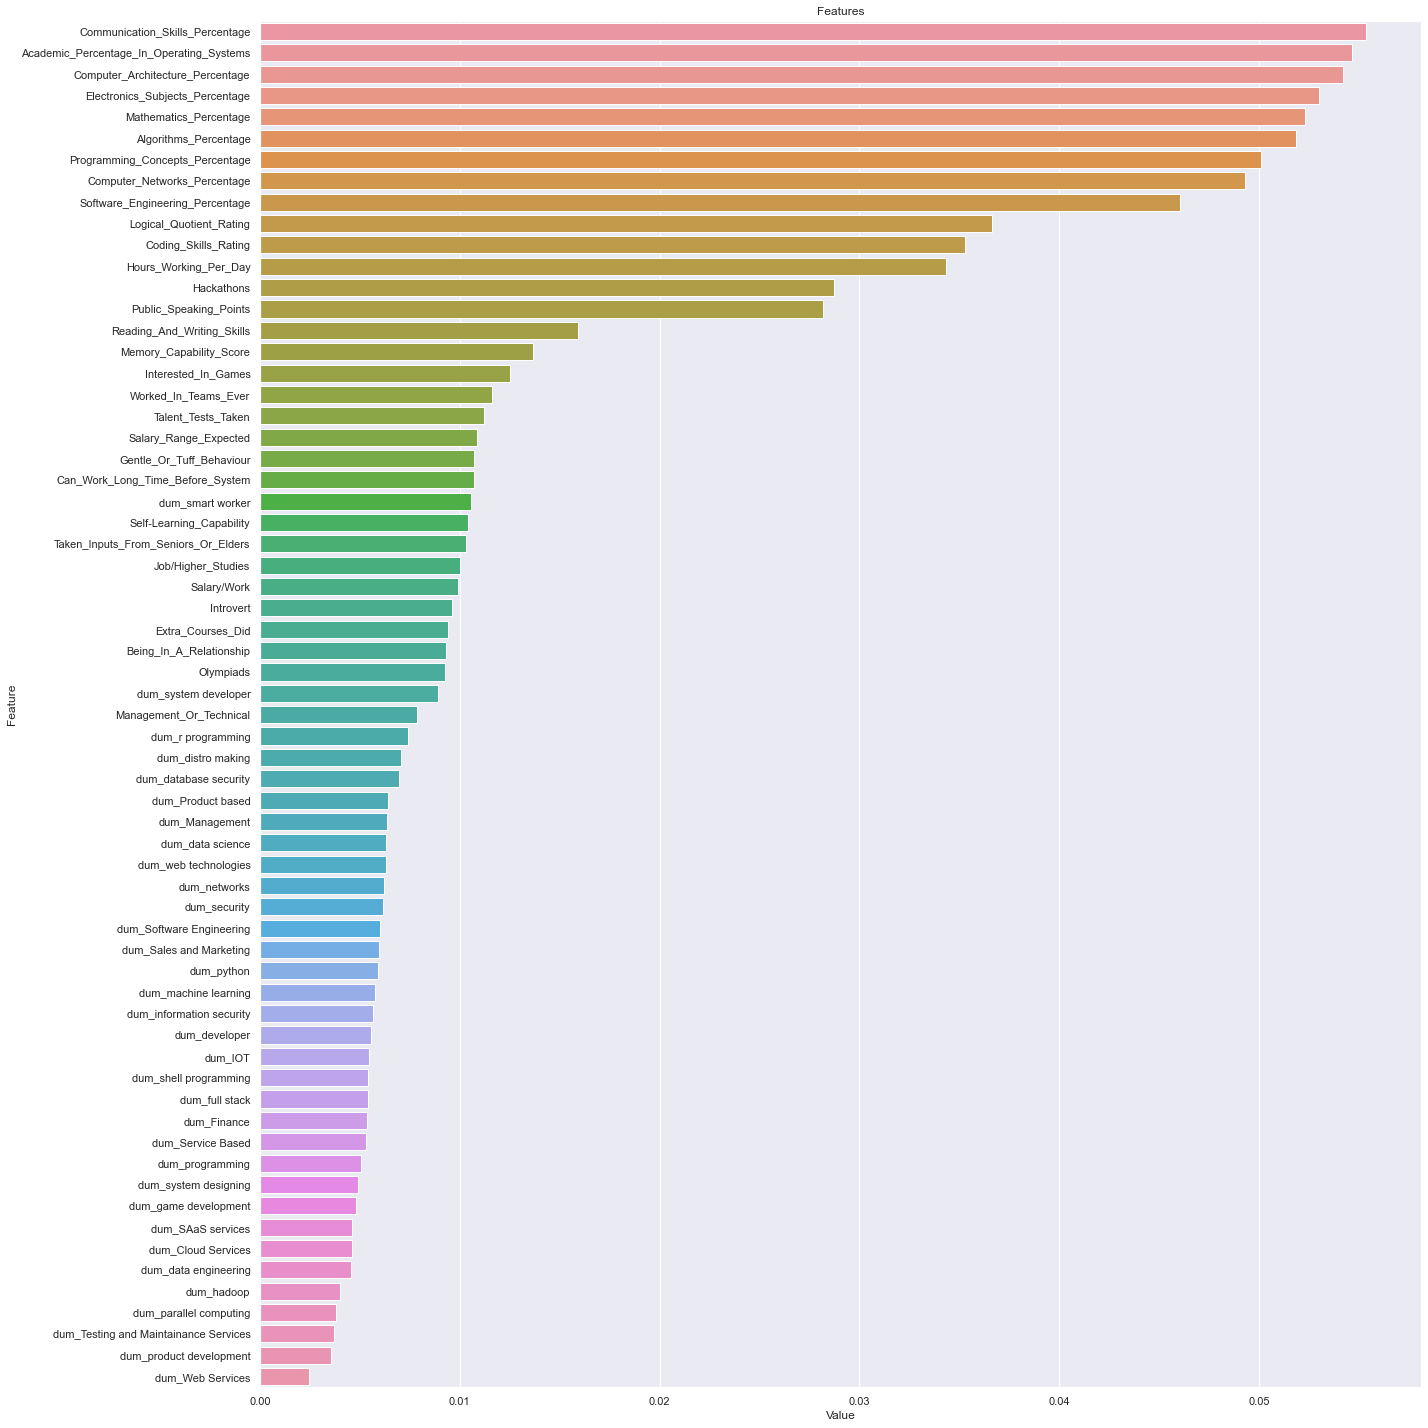

In [50]:
plot_importance(clf,X)

## Creating Models

In [112]:
X = df.drop(columns=["Suggested_Job_Role"],axis=1)
y = df["Suggested_Job_Role"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [52]:
clf = tree.DecisionTreeClassifier(random_state = 42)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[233  99 229 221 222 160]
 [102  49 105  90 108  74]
 [255 111 256 195 228 163]
 [216  88 227 173 205 145]
 [266 103 222 197 246 147]
 [166  78 189 138 163 131]]
  
accuracy= 18.133333333333333


In [53]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[316   0 470  97 267  14]
 [142   0 190  47 145   4]
 [277   0 508  98 308  17]
 [252   0 408 110 273  11]
 [290   0 462 114 301  14]
 [228   0 348  66 211  12]]
  
accuracy= 20.783333333333335


In [54]:
svmModel = svm.SVC()
svmModel.fit(X_train, y_train)
svm_y_pred = svmModel.predict(X_test)
svm_cm = confusion_matrix(y_test,svm_y_pred)
svm_accuracy = accuracy_score(y_test,svm_y_pred)
print("confusion matrics=\n",svm_cm)
print("  ")
print("accuracy=",svm_accuracy*100)

confusion matrics=
 [[295   0 438 103 326   2]
 [146   0 179  49 154   0]
 [317   0 468  94 328   1]
 [254   0 388 111 299   2]
 [272   0 475 108 322   4]
 [230   0 331  70 230   4]]
  
accuracy= 20.0


In [55]:
RFModel = RandomForestClassifier(random_state=0)
RFModel.fit(X_train, y_train)
rfc_y_pred = RFModel.predict(X_test)
rfc_cm = confusion_matrix(y_test,svm_y_pred)
rfc_accuracy = accuracy_score(y_test,rfc_y_pred)
print("confusion matrics=\n",rfc_cm)
print("  ")
print("accuracy=",rfc_accuracy*100)

confusion matrics=
 [[295   0 438 103 326   2]
 [146   0 179  49 154   0]
 [317   0 468  94 328   1]
 [254   0 388 111 299   2]
 [272   0 475 108 322   4]
 [230   0 331  70 230   4]]
  
accuracy= 19.25


# Neural Network

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense

In [57]:
df = shuffle(df)
X = df.drop(['Suggested_Job_Role'], axis = 1)
X = np.asarray(X).astype('float32')
Y = np.array(df['Suggested_Job_Role'])


In [58]:
l_encode = LabelEncoder()
l_encode.fit(Y)
Y = l_encode.transform(Y)
Y = to_categorical(Y)
Y = np.asarray(Y).astype('float32')

In [377]:
df.columns

Index(['Academic_Percentage_In_Operating_Systems', 'Algorithms_Percentage',
       'Programming_Concepts_Percentage', 'Software_Engineering_Percentage',
       'Computer_Networks_Percentage', 'Electronics_Subjects_Percentage',
       'Computer_Architecture_Percentage', 'Mathematics_Percentage',
       'Communication_Skills_Percentage', 'Hours_Working_Per_Day',
       'Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
       'Public_Speaking_Points', 'Can_Work_Long_Time_Before_System',
       'Self-Learning_Capability', 'Extra_Courses_Did', 'Talent_Tests_Taken',
       'Olympiads', 'Reading_And_Writing_Skills', 'Memory_Capability_Score',
       'Job/Higher_Studies', 'Taken_Inputs_From_Seniors_Or_Elders',
       'Interested_In_Games', 'Salary_Range_Expected',
       'Being_In_A_Relationship', 'Gentle_Or_Tuff_Behaviour',
       'Management_Or_Technical', 'Salary/Work', 'Worked_In_Teams_Ever',
       'Introvert', 'Suggested_Job_Role', 'dum_IOT', 'dum_Management',
       'dum_

In [455]:
samples = df[['Academic_Percentage_In_Operating_Systems', 'Algorithms_Percentage',
               'Programming_Concepts_Percentage', 'Software_Engineering_Percentage',
               'Computer_Networks_Percentage', 'Electronics_Subjects_Percentage',
               'Computer_Architecture_Percentage', 'Mathematics_Percentage',
               'Communication_Skills_Percentage', 'Hours_Working_Per_Day',
               'Logical_Quotient_Rating', 'Hackathons', 'Coding_Skills_Rating',
               'Public_Speaking_Points',
               'Self-Learning_Capability', 'Extra_Courses_Did', 'Talent_Tests_Taken', 'Reading_And_Writing_Skills', 'Memory_Capability_Score',
               'Job/Higher_Studies', 'Taken_Inputs_From_Seniors_Or_Elders',
               'Interested_In_Games', 'Salary_Range_Expected',
               'Being_In_A_Relationship', 'Gentle_Or_Tuff_Behaviour',
               'Management_Or_Technical', 'Worked_In_Teams_Ever']]

In [456]:
train_x, test_x, train_y, test_y = train_test_split(samples,Y, test_size = 0.3, random_state = 0)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((14000, 27), (14000,), (6000, 27), (6000,))

In [459]:
from keras.applications.densenet import layers

from keras.optimizers import Adam
df = shuffle(df)
model = Sequential()
model.add(Dense(20, input_dim=27))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(16))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(6))
model.add(layers.Activation('softmax'))

adam = Adam(lr=0.0001, epsilon=1e-8, decay=1e-4, amsgrad=False)
model.compile(loss = 'MSE', optimizer = adam, metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs = 20, batch_size = 32, validation_data=(test_x, test_y))
scores = model.evaluate(test_x, test_y)

for i, m in enumerate(model.metrics_names):
    print(m,scores[i])

Epoch 1/20
438/438 [==============================] - 3s 4ms/step - loss: 8.3768 - accuracy: 0.1631 - val_loss: 8.3653 - val_accuracy: 0.1660
Epoch 2/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3743 - accuracy: 0.1674 - val_loss: 8.3648 - val_accuracy: 0.1638
Epoch 3/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3736 - accuracy: 0.1637 - val_loss: 8.3645 - val_accuracy: 0.1668
Epoch 4/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3732 - accuracy: 0.1579 - val_loss: 8.3644 - val_accuracy: 0.1618
Epoch 5/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3731 - accuracy: 0.1662 - val_loss: 8.3643 - val_accuracy: 0.1562
Epoch 6/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3729 - accuracy: 0.1644 - val_loss: 8.3643 - val_accuracy: 0.1612
Epoch 7/20
438/438 [==============================] - 1s 3ms/step - loss: 8.3729 - accuracy: 0.1624 - val_loss: 8.3643 - val_accuracy: 0.1715
Epoch 

In [460]:
y_pred = model.predict(test_x)

188/188 [==============================] - 0s 1ms/step


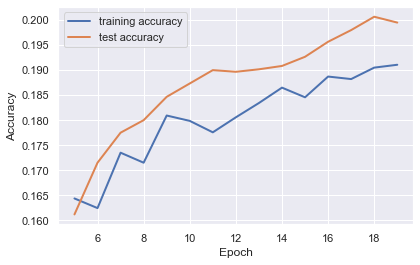

In [461]:
logs = pd.DataFrame(history.history)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[5:,"val_accuracy"], lw=2, label='test accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

Although we tried many times with different structures, we encountered an overfit situation. That's why we started trying different solutions.

### Transfer Learning

We tried but we cannot find an appropriate model for our dataset

In [62]:
df = shuffle(df)
X = df.drop(['Suggested_Job_Role'], axis=1)
X = np.asarray(X).astype('float32')
Y = np.array(df['Suggested_Job_Role'])

l_encode = LabelEncoder()
l_encode.fit(Y)
Y = l_encode.transform(Y)

In [63]:
classes = {0:"Project Manager",
           1:"Security Administrator",
           2:"Software Developer",
           3:"Business Intelligence Analyst",
           4:"Technical Support",
           5:"Database Administrator"}

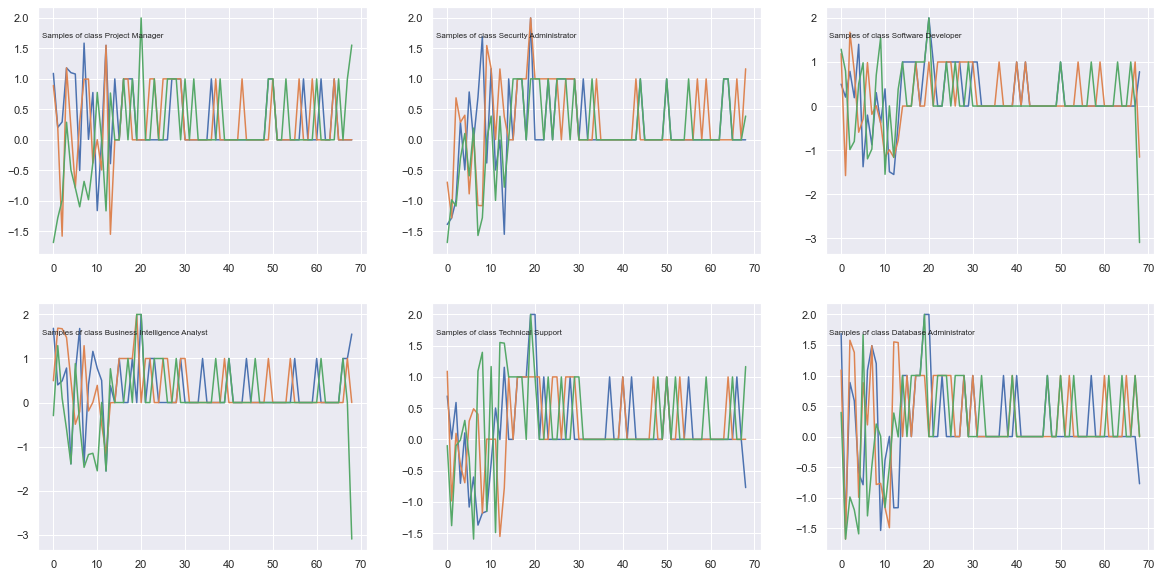

In [64]:
for i in range(0,6):
    plt.subplot(2,3,i + 1)
    all_samples_indexes = np.where(Y == i)[0]
    rand_samples_indexes = np.random.randint(0, len(all_samples_indexes), 3)
    rand_samples = X[rand_samples_indexes]
    plt.plot(rand_samples.transpose())
    plt.title("Samples of class " + classes[i], loc='left', fontdict={'fontsize':8}, x=0.01, y=0.85)

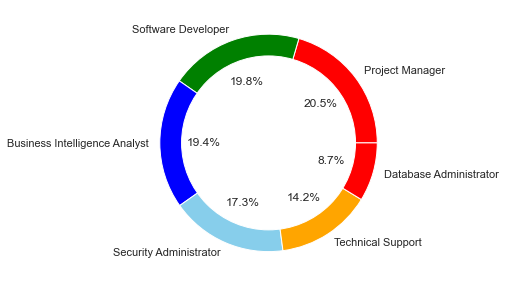

In [65]:
repartition = [4099,3968,3889,3468,2832,1744]

plt.figure(figsize=(5, 5))
circle = plt.Circle((0, 0), 0.8, color='white')
plt.pie(repartition, labels=['Project Manager', 'Software Developer', 'Business Intelligence Analyst', 'Security Administrator', 'Technical Support','Database Administrator'], colors=['red', 'green', 'blue', 'skyblue', 'orange'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

## XGBoost

In [67]:
from xgboost import XGBClassifier
eval_set = [(X_train, y_train), (X_test, y_test)]

model_xgb=XGBClassifier(objective='multi:softmax',
                        num_class=3,
                        missing=0,
                        gamma=1, # default gamma value
                        learning_rate=0.002,
                        max_depth=3,
                        reg_lambda=1, # default L2 value
                        subsample=1, # default subsample value
                        colsample_bytree=1, # default colsample_bytree value
                        early_stopping_rounds=10,
                        eval_metric=['merror','mlogloss'],
                        seed=0)
model_xgb.fit(X_train,y_train, eval_set=eval_set,verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['merror', 'mlogloss'], feature_types=None, gamma=1,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.002, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax', ...)

In [68]:
y_pred = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.202
Accuracy: 20.20%


In [69]:
test_size = 6000

# pred_ = np.argmax(y_pred,axis=1)

pred_ = l_encode.inverse_transform(y_pred)

# true_y = np.argmax(y_test,axis=1)
# true_y = l_encode.inverse_transform(y_test)
true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test[:test_size]), axis = 1))

count = 0
for i,j in zip(pred_, true_y):
    #print("Predicted: {}, True: {}".format(i, j))
    if i==j:
        print(j)
        count +=1
print(count)

Software Developer
Software Developer
Software Developer
Project Manager
Business Intelligence Analyst
Project Manager
Software Developer
Project Manager
Business Intelligence Analyst
Project Manager
Software Developer
Software Developer
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Software Developer
Software Developer
Project Manager
Project Manager
Business Intelligence Analyst
Project Manager
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Software Developer
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Software Developer
Business Intelligence Analyst
Project Manager
Business Intelligence Analyst
Software Developer
Project Manager
Software Developer
Business Intelligence Analyst
Business Intelligence Analyst
Business Intelligence Analyst


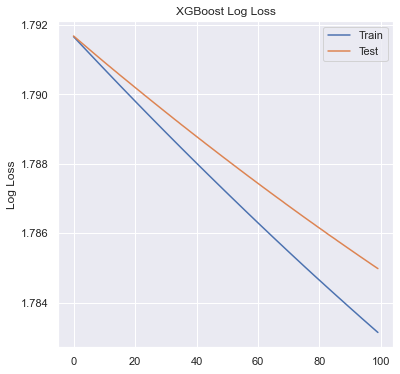

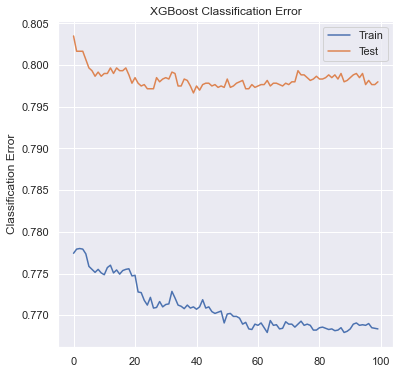

In [70]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

results = model_xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(6,6))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(6,6))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()

pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

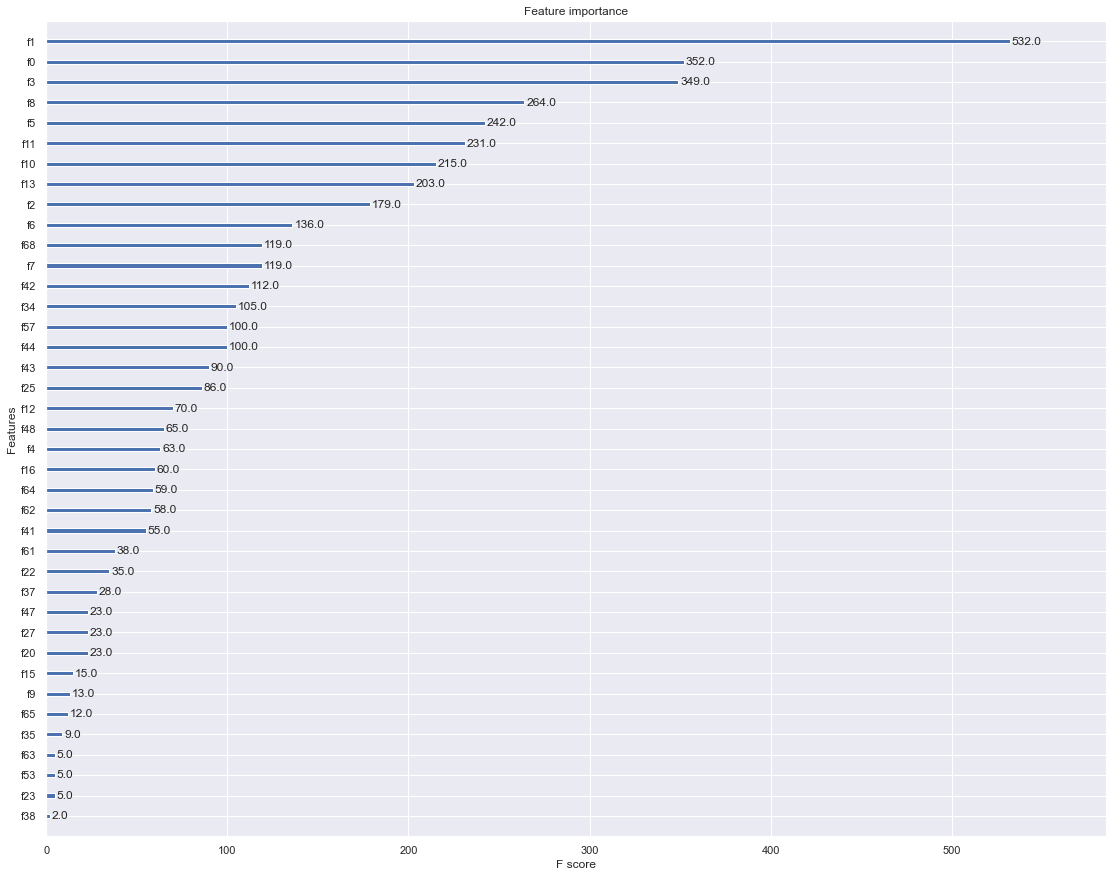

In [71]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(19,15))
plot_importance(model_xgb, ax=ax)
plt.show()

In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    algorithm: {'SAMME','SAMME.R'}, optional(default='SAMME.R')
        SAMME.R uses predicted probabilities to update wights, while SAMME uses class error rate
    random_state: int or None, optional(default=None)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    Reference:
    1. [multi-adaboost](https://web.stanford.edu/~hastie/Papers/samme.pdf)
    2. [scikit-learn:weight_boosting](https://github.com/scikit-learn/
    scikit-learn/blob/51a765a/sklearn/ensemble/weight_boosting.py#L289)


In [106]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),n_estimators=100,learning_rate= 0.0001, random_state=0,algorithm="SAMME")
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.0001, n_estimators=100, random_state=0)

In [107]:
predictions = ada.predict(X_test)

In [108]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.19      0.18      0.18      1145
           1       0.08      0.01      0.01       509
           2       0.22      0.62      0.32      1265
           3       0.18      0.09      0.12      1043
           4       0.21      0.12      0.15      1204
           5       0.00      0.00      0.00       834

    accuracy                           0.21      6000
   macro avg       0.14      0.17      0.13      6000
weighted avg       0.16      0.21      0.16      6000



In [76]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print(accuracy)

0.18583333333333332


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.212
Accuracy score (validation): 0.212
Learning rate:  0.075
Accuracy score (training): 0.220
Accuracy score (validation): 0.212
Learning rate:  0.1
Accuracy score (training): 0.226
Accuracy score (validation): 0.213
Learning rate:  0.25
Accuracy score (training): 0.232
Accuracy score (validation): 0.204
Learning rate:  0.5
Accuracy score (training): 0.236
Accuracy score (validation): 0.204
Learning rate:  0.75
Accuracy score (training): 0.243
Accuracy score (validation): 0.199
Learning rate:  1
Accuracy score (training): 0.242
Accuracy score (validation): 0.197


In [78]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.05, max_features=2, max_depth=6, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

accuracy = gb_clf2.score(X_test, y_test)
print(accuracy)

Confusion Matrix:
[[245   0 567   4 329   0]
 [125   0 246   4 134   0]
 [285   0 642  10 328   0]
 [241   0 519  12 271   0]
 [280   0 596   9 319   0]
 [190   0 416   7 221   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.18      0.21      0.20      1145
           1       0.00      0.00      0.00       509
           2       0.22      0.51      0.30      1265
           3       0.26      0.01      0.02      1043
           4       0.20      0.26      0.23      1204
           5       0.00      0.00      0.00       834

    accuracy                           0.20      6000
   macro avg       0.14      0.17      0.12      6000
weighted avg       0.16      0.20      0.15      6000

0.203


In [79]:
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
print("confusion matrix=\n",cm)
print("  ")
print("accuracy=",accuracy*100)

confusion matrix=
 [[301   0 386 123 310  25]
 [157   0 159  59 125   9]
 [349   0 417 140 324  35]
 [276   0 345 101 289  32]
 [318   0 390 143 322  31]
 [247   0 264  86 215  22]]
  
accuracy= 19.383333333333333


In [80]:
param_grid_lr = {
    'max_iter': [5,10,20, 50, 100, 200, 500, 1000],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced']
}

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [265]:
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(X_train, y_train)
print(logModel_grid.best_estimator_)

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


KeyboardInterrupt: 

In [314]:
log_model = LogisticRegression(C=0.001, class_weight='balanced', max_iter=5, random_state=42,solver='liblinear',penalty="l1")
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(y_pred)

['Project Manager' 'Project Manager' 'Security Administrator' ...
 'Security Administrator' 'Project Manager' 'Software Developer']


In [315]:
accuracy = accuracy_score(y_test,y_pred)

In [316]:
accuracy

0.1995

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,51):
    classifier = KNeighborsClassifier(n_neighbors = i,weights ="distance")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print("K: ",i,"Accuracy: ",accuracy)
#k=49

In [251]:
from sklearn.naive_bayes import MultinomialNB

In [254]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [255]:
print(accuracy_score(y_test,y_pred))

0.20666666666666667


In [319]:
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier

In [ ]:
from sklearn.svm import SVC
votingClf = VotingClassifier([('clf1',SVC(probability=True)),('clf2',DecisionTreeClassifier())],voting='soft') #

In [321]:
adaBoostClassifier = AdaBoostClassifier(base_estimator = votingClf)
adaBoostClassifier.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=VotingClassifier(estimators=[('clf1',
                                                                SVC(probability=True)),
                                                               ('clf2',
                                                                DecisionTreeClassifier())],
                                                   voting='soft'))

In [322]:
y_pred = adaBoostClassifier.predict(X_test)

In [323]:
print(accuracy_score(y_test,y_pred))

0.17733333333333334
